# HMDB51 - Human Action Recognition using Pytorch

## Importing Libraries

In [1]:
!pip install -U -q -r requirements.txt

In [2]:
import os
import shutil
import rarfile
import random
import requests
import numpy as np
import pandas as pd
import gradio as gr
from tqdm.auto import tqdm
from timeit import default_timer as timer
from collections import Counter
from sklearn.model_selection import train_test_split

import cv2
from IPython.display import Video, IFrame
import matplotlib.pyplot as plt

import torch
import torchvision
import torchmetrics
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torchvision.io import read_video
from torchvision.models.video import mvit_v2_s, MViT_V2_S_Weights
import lightning as L
from lightning.fabric import Fabric

In [3]:
print(f'Torch version: {torch.__version__}')
print(f'Torchvision version: {torchvision.__version__}')
print(f'Lightning version: {L.__version__}')
print(f'GPU score: {torch.cuda.get_device_capability()}')

Torch version: 2.0.0+cu117
Torchvision version: 0.15.1+cu117
Lightning version: 2.0.1
GPU score: (8, 6)


In [4]:
# Setting seed for randomness
def set_seed(seed: int = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)

set_seed(42)

# setting the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Downloading the Dataset

Downloading the data from the dataset origin.

In [5]:
DATA_URL = 'http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar'
RAW_DATA_PATH = 'raw_data'
DATA_PATH = 'data'
HMDB_DATA_PATH = os.path.join(DATA_PATH, 'HMDB51')

In [6]:
if os.path.isfile('hmdb51_org.rar'):
    print('[INFO] Data already exists!')
else:
    print('[INFO] Downloading data.')
    r = requests.get(DATA_URL)
    with open('hmdb51_org.rar', 'wb') as file:
        file.write(r.content)
        file.close()
    print('[INFO] Data is been downloaded!')

[INFO] Downloading data.
[INFO] Data is been downloaded!


Extracting the data in the raw_data directory

In [7]:
if os.path.exists(RAW_DATA_PATH):
    print('[INFO] Data path already exists!')
else:
    print('[INFO] Extracting data.')
    os.mkdir(RAW_DATA_PATH)
    r = rarfile.RarFile('hmdb51_org.rar')
    r.extractall(RAW_DATA_PATH)
    r.close()
    print('[INFO] Data extraction done!')

[INFO] Extracting data.
[INFO] Data extraction done!


Extracting all the raw data in the data directory and deleting the raw data from the system..

In [8]:
if os.path.exists(DATA_PATH):
    print('[INFO] Data path already exists!')
else:
    print('[INFO] Extracting all the classes data.')
    os.mkdir(DATA_PATH)
    for data in os.listdir(RAW_DATA_PATH):
        r = rarfile.RarFile(os.path.join(RAW_DATA_PATH, data))
        r.extractall(DATA_PATH)
        r.close()
        print(f'[INFO] Data extraction done for: "{os.path.join(RAW_DATA_PATH, data)}"!')
    os.remove('hmdb51_org.rar')
    shutil.rmtree(RAW_DATA_PATH)
    print(f'\n[INFO] Deleted raw data.')

[INFO] Extracting all the classes data.
[INFO] Data extraction done for: "raw_data/clap.rar"!
[INFO] Data extraction done for: "raw_data/talk.rar"!
[INFO] Data extraction done for: "raw_data/smoke.rar"!
[INFO] Data extraction done for: "raw_data/draw_sword.rar"!
[INFO] Data extraction done for: "raw_data/flic_flac.rar"!
[INFO] Data extraction done for: "raw_data/dive.rar"!
[INFO] Data extraction done for: "raw_data/shoot_bow.rar"!
[INFO] Data extraction done for: "raw_data/drink.rar"!
[INFO] Data extraction done for: "raw_data/hug.rar"!
[INFO] Data extraction done for: "raw_data/pour.rar"!
[INFO] Data extraction done for: "raw_data/pushup.rar"!
[INFO] Data extraction done for: "raw_data/hit.rar"!
[INFO] Data extraction done for: "raw_data/wave.rar"!
[INFO] Data extraction done for: "raw_data/run.rar"!
[INFO] Data extraction done for: "raw_data/walk.rar"!
[INFO] Data extraction done for: "raw_data/fall_floor.rar"!
[INFO] Data extraction done for: "raw_data/ride_horse.rar"!
[INFO] Data e

Checking some info on the data that is been extracted.

In [9]:
for dirpath, dirnames, filenames in os.walk(DATA_PATH):
    print(f'There are {len(dirnames)} directories and {len(filenames)} files in "{dirpath}".')

There are 51 directories and 0 files in "data".
There are 0 directories and 143 files in "data/swing_baseball".
There are 0 directories and 232 files in "data/run".
There are 0 directories and 105 files in "data/situp".
There are 0 directories and 162 files in "data/shake_hands".
There are 0 directories and 107 files in "data/flic_flac".
There are 0 directories and 127 files in "data/hit".
There are 0 directories and 102 files in "data/kiss".
There are 0 directories and 120 files in "data/talk".
There are 0 directories and 164 files in "data/drink".
There are 0 directories and 104 files in "data/wave".
There are 0 directories and 140 files in "data/somersault".
There are 0 directories and 116 files in "data/push".
There are 0 directories and 116 files in "data/ride_horse".
There are 0 directories and 128 files in "data/kick_ball".
There are 0 directories and 105 files in "data/golf".
There are 0 directories and 112 files in "data/shoot_bow".
There are 0 directories and 116 files in "da

## Visualizing the dataset

Now that the data is downloaded, lets view the data with the labels.

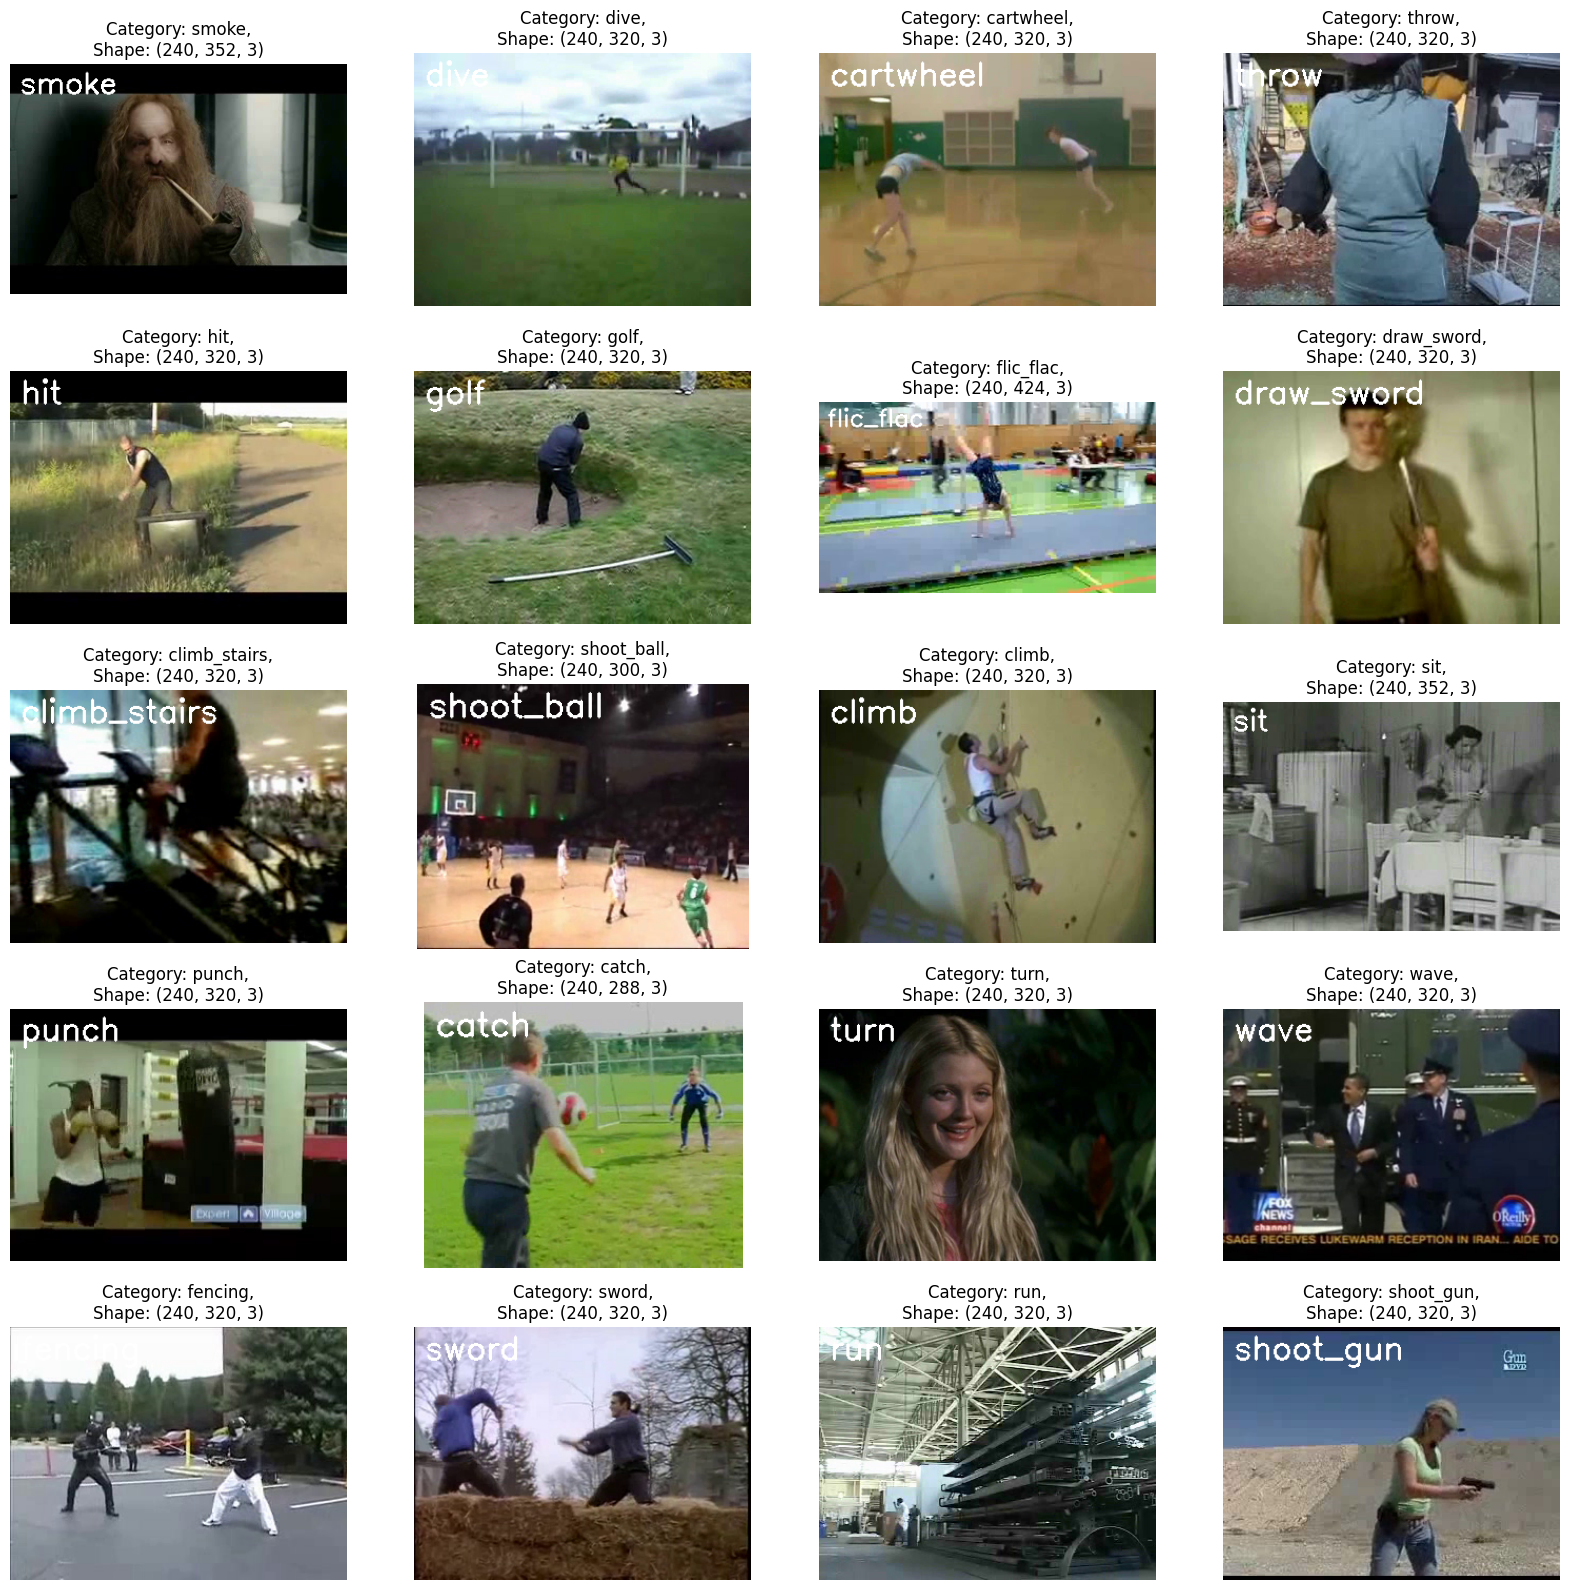

In [10]:
plt.figure(figsize=(20, 20))
CLASSES = sorted(os.listdir(DATA_PATH))

# Selecting 20 random categories for visualization
random_range = random.sample(range(len(CLASSES)), 20)

for i, rand_i in enumerate(random_range, 1):
    class_name = CLASSES[rand_i]

    # Looking for the video files in the category and selecting it randomly
    video_files_list = os.listdir(os.path.join(DATA_PATH, class_name))
    video_file_name = random.choice(video_files_list)

    # Reading the video file and displaying the first frame with label.
    video_reader = cv2.VideoCapture(os.path.join(DATA_PATH, class_name, video_file_name))
    _, frame = video_reader.read()
    video_reader.release()
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cv2.putText(rgb_frame, class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    plt.subplot(5, 4, i)
    plt.title(f'Category: {class_name},\nShape: {rgb_frame.shape}')
    plt.imshow(rgb_frame)
    plt.axis(False);

## Preprocessing the Dataset

Creating pytorch Dataset.

In this steps we will be creating a custom dataset class using the functionality provided by PyTorch.
1. Read the video file.
2. Extracting the frames after every distance for a max sequence length.
3. Assigning label index for all the classes.
4. Performing torchvision.transform on the video data.
5. Returning tuple of video and label data as a tensor.

In [11]:
# Defining variables
SEQUENCE_LENGTH = 16 # Frames feeded to the model as a single sequence
NUM_CLASSES = 20 # Selecting 20 classes from 51 classes

Before creating the dataset, first lets clean it.<br> 
Here we will check whether the videos are readable and the frame count needs to be more than the Sequence Length frames.

In [12]:
files_list = [os.path.join(DATA_PATH, dir, video) for dir in CLASSES for video in os.listdir(DATA_PATH + "/" + dir)]
remove_file_list = []
for file in files_list:
    vframes, _, _ = read_video(filename=file, pts_unit='sec', output_format='TCHW')
    if len(vframes) <= SEQUENCE_LENGTH:
        print(f'File Name: {file} and Total Frames Count: {len(vframes)}')
        remove_file_list.append(file)
remove_file_list

[]

In [13]:
# Deleting the video files
if len(remove_file_list) > 0:
    for file_path in remove_file_list:
        try: 
            os.remove(path=file_path)
            print(f'File "{file_path}" is been deleted')
        except FileNotFoundError:
            print('File is missing or is been already deleted')
else:
    print('There are no files to delete.')

There are no files to delete.


In [14]:
class HumanActionDataset(Dataset):
    """
    A class to create a PyTorch dataset using the video files directory,
    transforming the video data and returning the data and labels for every index.
    
    Parameters:
        video_dir: str, A string containing the path for all the video categories or classes.
        seq_len: int(default: 20), A integer specifing the required total sequence frames.
        num_classes: int(default: 20), Selecting random classes and the max allowed is 51 classes for this dataset.
        transform: default: None, A torchvision transforms for applying multiple transformation on every frame.
    Returns:
        selected_frame, label: tuple, A tuple containing the video "TCHW" and label data in tensor format. 
    """
    def __init__(self, video_dir: str, seq_len: int, num_classes: int, transform=None):
        self.video_dir = video_dir
        self.seq_len = seq_len
        self.num_classes = num_classes
        self.transform = transform 
        
        # Creating a list of all the video files path and classes.
        set_seed(seed=42)
        if self.num_classes > 51:
            self.num_classes = 51
        self.classes = random.sample(sorted(os.listdir(video_dir)), k=self.num_classes)
        self.files_list = [os.path.join(video_dir, dir, video) for dir in self.classes for video in os.listdir(video_dir + "/" + dir)]
        
    def __len__(self):
        return len(self.files_list)
    
    def __getitem__(self, index):
        video_path = self.files_list[index]
        
        # Reading the video file
        vframes, _, _ = read_video(filename=video_path, pts_unit='sec', output_format='TCHW')
        vframes = vframes.type(torch.float32)
        vframes_count = len(vframes)
        
        # Selecting frames at certain interval
        skip_frames = max(int(vframes_count/self.seq_len), 1)
        selected_frame = vframes[0].unsqueeze(0)
        
        # Creating a new sequence of frames upto the defined sequence length.
        for i in range(1, self.seq_len):
            selected_frame = torch.concat((selected_frame, vframes[i * skip_frames].unsqueeze(0)))
            
        # Video label as per the classes list.
        label = torch.tensor(self.classes.index(video_path.split('/')[1]))
        
        # Applying transformation to the frames
        if self.transform:
            return self.transform(selected_frame), label
        else:
            return selected_frame, label

In [15]:
# Creating the dataset
dataset = HumanActionDataset(video_dir=DATA_PATH, seq_len=SEQUENCE_LENGTH, num_classes=NUM_CLASSES)
print(f'Length of the dataset: {len(dataset)}')

# Checking the dataset shape
frames, label = dataset[2000]
print(f'Video tensor(first frame):\n{frames[0]}\nlabel tensor: {label}')
print(f'Shape of the video tensor: {frames.shape} and shape of the label: {label.shape}')

Length of the dataset: 2530
Video tensor(first frame):
tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  1.,  1.,  1.],
         [ 2.,  2.,  0.,  ..., 11., 11., 11.],
         ...,
         [ 2.,  2.,  0.,  ..., 55., 55., 55.],
         [ 5.,  5.,  3.,  ..., 62., 62., 62.],
         [ 5.,  5.,  2.,  ..., 34., 34., 34.]],

        [[ 4.,  4.,  5.,  ...,  2.,  1.,  1.],
         [ 5.,  5.,  5.,  ...,  3.,  3.,  3.],
         [ 4.,  4.,  5.,  ..., 17., 17., 17.],
         ...,
         [ 2.,  2.,  2.,  ..., 41., 41., 41.],
         [ 0.,  0.,  1.,  ..., 49., 49., 49.],
         [ 0.,  0.,  0.,  ..., 21., 21., 21.]],

        [[ 3.,  3.,  4.,  ...,  2.,  1.,  1.],
         [ 4.,  4.,  4.,  ...,  3.,  3.,  3.],
         [ 1.,  1.,  1.,  ...,  8.,  8.,  8.],
         ...,
         [ 0.,  0.,  0.,  ..., 16., 14., 14.],
         [ 0.,  0.,  0.,  ..., 28., 28., 28.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]]])
label tensor: 16
Shape of the video tensor: torch.S

## Creating A Pretrained Model

In [16]:
def create_model(num_classes: int, device: torch.device, seed: int = 42):
    """
    A function to create a model.
    Parameters:
        num_classes: int, A integer for toal number of classes.
        device: torch.device, A torch device to set the tensors to cpu or cuda.
        seed: int(default: 42), A random seed value.
    Returns: 
        model: A feature extracted model for video classification.
        transforms: A torchvision transform is returned which was used in the pretrained model.    
    """
    # Creating model, weights and transforms
    weights = MViT_V2_S_Weights.DEFAULT
    transforms = weights.transforms()
    model = mvit_v2_s(weights=weights)
    
    # Freezing the model layers
    for params in model.parameters():
        params.requires_grad = False
        
    # Changing the fully Conncected head layer
    set_seed(seed)
    dropout_layer = model.head[0]
    in_features = model.head[1].in_features
    model.head = torch.nn.Sequential(
        dropout_layer,
        torch.nn.Linear(in_features=in_features, out_features=num_classes, bias=True, device=device)
    )
    return model.to(device), transforms

In [17]:
# Creating the model and transforms using the function.
model, transforms = create_model(num_classes=len(dataset.classes), device=device)

In [18]:
summary(model, 
        input_size=(1, 3, 16, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
MViT (MViT)                                        [1, 3, 16, 224, 224] [1, 20]              --                   Partial
├─Conv3d (conv_proj)                               [1, 3, 16, 224, 224] [1, 96, 8, 56, 56]   (42,432)             False
├─PositionalEncoding (pos_encoding)                [1, 25088, 96]       [1, 25089, 96]       (96)                 False
├─ModuleList (blocks)                              --                   --                   --                   False
│    └─MultiscaleBlock (0)                         [1, 25089, 96]       [1, 25089, 96]       --                   False
│    │    └─LayerNorm (norm1)                      [1, 25089, 96]       [1, 25089, 96]       (192)                False
│    │    └─MultiscaleAttention (attn)             [1, 25089, 96]       [1, 25089, 96]       (68,352)             False
│    │    └─StochasticDepth (stoch

In [19]:
# Checking the model transforms and applying it on the dataset
print(f'Pretrained Model Transforms:\n{transforms}\n')
dataset = HumanActionDataset(video_dir=DATA_PATH, seq_len=SEQUENCE_LENGTH, num_classes=NUM_CLASSES, transform=transforms)
print(f'Length of the dataset: {len(dataset)}')

# Checking the dataset and shape
frames, label = dataset[2000]
print(f'Video tensor(first frame):\n{frames[0]}\nlabel tensor: {label}')
print(f'Shape of the video tensor: {frames.shape} and shape of the label: {label.shape}')

Pretrained Model Transforms:
VideoClassification(
    crop_size=[224, 224]
    resize_size=[256]
    mean=[0.45, 0.45, 0.45]
    std=[0.225, 0.225, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

Length of the dataset: 2530
Video tensor(first frame):
tensor([[[ 2.4604e+02,  2.3502e+02,  2.2911e+02,  ...,  2.8675e+02,
           2.8675e+02,  2.8684e+02],
         [ 2.3070e+02,  2.2561e+02,  2.1813e+02,  ...,  3.1508e+02,
           3.1508e+02,  3.1508e+02],
         [ 2.3060e+02,  2.2712e+02,  2.1802e+02,  ...,  3.1425e+02,
           3.1425e+02,  3.1425e+02],
         ...,
         [ 3.2401e+00,  2.9817e+00, -2.0000e+00,  ...,  1.6333e+02,
           1.2992e+02,  9.1900e+01],
         [-1.5833e+00, -1.7232e+00, -2.0000e+00,  ...,  4.4867e+02,
           3.7443e+02,  2.8330e+02],
         [ 2.4444e+00,  9.5210e-01, -2.0000e+00,  ...,  6.6754e+02,
           6.3805e+02,  5.6134e+02]],

        [[ 2.2467e+02,  2.2616e+02,  2.2911e+02,  ...,  3.0883e+02,
           3.0883e+02,  3.09

## Creating DataLoaders

In [20]:
# Spliting the dataset in train and test dataset for ratio of 75:25.
dataset = HumanActionDataset(video_dir=DATA_PATH, 
                             seq_len=SEQUENCE_LENGTH,
                             num_classes=NUM_CLASSES,
                             transform=transforms)
train_dataset, test_dataset = random_split(dataset=dataset,
                                           lengths=[0.75, 0.25], 
                                           generator=torch.Generator().manual_seed(42))
print(f'Train Dataset Length: {len(train_dataset)} and Test Dataset length: {len(test_dataset)}')

Train Dataset Length: 1898 and Test Dataset length: 632


In [21]:
# Creating train and test dataloaders.
def create_dataloaders(dataset, batch, shuffle, workers):
    """
    A function to create pytorch dataloaders.
    
    Parameters:
        dataset: A pytorch dataset.
        batch: A integer for batch size.
        shuffle: A boolean for shuffling the data.
        workers: A integer to set the workers in dataloaders.
        
    Returns: dataloader.
    """
    dataloader = DataLoader(dataset=dataset, 
                            batch_size=batch, 
                            shuffle=shuffle, 
                            num_workers=workers,
                            pin_memory=True,
                            drop_last=True)
    print(f'Dataloaders Length: {len(dataloader)} for a batch size of: {batch}')
    return dataloader

set_seed(42)
BATCH_SIZE = 16
WORKERS = os.cpu_count()
train_dataloader = create_dataloaders(dataset=train_dataset, batch=BATCH_SIZE, shuffle=True, workers=WORKERS)
test_dataloader = create_dataloaders(dataset=test_dataset, batch=BATCH_SIZE, shuffle=False, workers=WORKERS)

Dataloaders Length: 118 for a batch size of: 16
Dataloaders Length: 39 for a batch size of: 16


**Label Distribution and Zero Rule Benchmark**

In [22]:
train_counter = Counter()
for frames, labels in train_dataloader:
    train_counter.update(labels.tolist())
print('Training Dataset Distribution:\n', sorted(train_counter.items()))

Training Dataset Distribution:
 [(0, 78), (1, 92), (2, 83), (3, 79), (4, 94), (5, 72), (6, 77), (7, 79), (8, 85), (9, 103), (10, 90), (11, 106), (12, 88), (13, 78), (14, 180), (15, 70), (16, 87), (17, 100), (18, 171), (19, 76)]


In [23]:
test_counter = Counter()
for frames, labels in test_dataloader:
    test_counter.update(labels.tolist())
print('Testing Dataset Distribution:\n', sorted(test_counter.items()))

Testing Dataset Distribution:
 [(0, 30), (1, 32), (2, 24), (3, 23), (4, 29), (5, 32), (6, 30), (7, 24), (8, 27), (9, 27), (10, 17), (11, 35), (12, 37), (13, 24), (14, 58), (15, 33), (16, 29), (17, 26), (18, 60), (19, 27)]


In [24]:
# Zero Rule Benchmark
major_class = test_counter.most_common(1)[0]
print(f'The Major class in Testing DataLoader is: Class Name: {CLASSES[major_class[0]]}, Class Index: {major_class[0]} and Total Number of Data: {major_class[1]}')

zero_rule_acc = (major_class[1] / sum(test_counter.values())) * 100
print(f'Zero Rule Basline Benchmark Accuracy for predicting the major class: {zero_rule_acc:.2f}%')

The Major class in Testing DataLoader is: Class Name: hug, Class Index: 18 and Total Number of Data: 60
Zero Rule Basline Benchmark Accuracy for predicting the major class: 9.62%


## PyTorch - Model Training and Testing

In [54]:
def train_step(model, dataloader, loss_fn, optimizer, device, num_classes):
    """
    Trains a pytorch model by going into train mode and applying forward pass,
    loss calculation and optimizer step.
    
    Parameters:
        model: A pytorch model for training.
        dataloader: A pytorch dataloader for training.
        loss_fn: A pytorch loss to calculate the model's prediction loss.
        optimizer: A pytorch optimizer to minimize the loss function.
        device: A torch device to allocate tensors on 'cpu' or 'cuda'.
        num_classes: A integer that indicates total number of classes in the dataset.
        
    Returns: A tuple of training loss and training accuracy.
        
    """
    # Model on training mode
    model.train()
    
    # Setting train loss and accuracy 
    train_loss = 0
    train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes).to(device)
    
    # Looping the dataloaders
    for batch, (X, y) in tqdm(enumerate(dataloader), desc='Model Training', total=len(dataloader), unit='batch'):
        X, y = X.to(device), y.to(device)
        
        # 5 step to train a model
        y_pred = model(X) # 1. Forward pass
        loss = loss_fn(y_pred, y) # 2. Calculate loss
        train_loss += loss.item() 
        optimizer.zero_grad() # 3. Initiate optimizer
        loss.backward() # 4. Backward pass
        optimizer.step() # 5. Updating the model parameters
        
        # Calculating the training accuracy
        y_pred_labels = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc.update(y_pred_labels, y)
    
    # Averaging the loss and accuracy
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc.compute()
    return train_loss, train_acc

def test_step(model, dataloader, loss_fn, device, num_classes):
    """
    Test a pytorch model by going into eval mode and applying forward pass,
    and loss calculation.
    
    Parameters:
        model: A pytorch model for testing.
        dataloader: A pytorch dataloader for testing.
        loss_fn: A pytorch loss to calculate the model's prediction loss.
        device: A torch device to allocate tensors on 'cpu' or 'cuda'.
        num_classes: A integer that indicates total number of classes in the dataset.
        
    Returns: A tuple of testing loss and testing accuracy.
    """
    # Model on evaluation mode
    model.eval()
    
    # Setting train loss and accuracy 
    test_loss = 0
    test_acc = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes).to(device)
    
    # Using inference mode
    with torch.no_grad():
        # Looping the dataloaders
        for batch, (X, y) in tqdm(enumerate(dataloader), desc='Model Evaluation', total=len(dataloader), unit='batch'):
            X, y = X.to(device), y.to(device)
            
            # Forward pass
            y_pred = model(X)
            
            # Calculate loss
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()
            
            # Calculate accuracy
            y_pred_labels = y_pred.argmax(dim=1)
            test_acc.update(y_pred_labels, y)
    
    # Averaging the loss and accuracy
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc.compute()
    return test_loss, test_acc

def model_train(epochs, model, train_dataloader, test_dataloader, optimizer, loss_fn, device, num_classes):
    """
    Trains a pytorch model for a certain number of epochs going through the model training 
    and testing stage, and accumalating the loss, accuracy, and training and testing time.
    
    Parameters:
        epochs: A integer to run the training and testing stage. 
        model: A pytorch model for training and testing.
        train_dataloader: A pytorch dataloader for training.
        test_dataloader: A pytorch dataloader for testing.
        loss_fn: A pytorch loss to calculate the model's prediction loss.
        optimizer: A pytorch optimizer to minimize the loss function.
        device: A torch device to allocate tensors on 'cpu' or 'cuda'.
        num_classes: A integer that indicates total number of classes in the dataset.
        
    Returns: A tuple of accumaleted results in dict and total training time in float datatype.
    """
    # Create empty result
    results = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': [],
               'train_epoch_time(min)': [],
               'test_epoch_time(min)': []}
    
    # Loop through training and testing steps
    model_train_start_time = timer()
    for epoch in tqdm(range(epochs), desc=f'Training and Evaluation for {epochs} Epochs', unit='epochs'):
        # Training the model and timing it.
        train_epoch_start_time = timer()
        train_loss, train_acc = train_step(model=model, 
                                           dataloader=train_dataloader, 
                                           loss_fn=loss_fn, 
                                           optimizer=optimizer, 
                                           device=device, 
                                           num_classes=num_classes)
        train_epoch_stop_time = timer()
        train_epoch_time = (train_epoch_stop_time - train_epoch_start_time)/60
        
        # Testing the model and timing it
        test_epoch_start_time = timer()
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device,
                                        num_classes=num_classes)
        test_epoch_stop_time = timer()
        test_epoch_time = (test_epoch_stop_time - test_epoch_start_time)/60
        
        # Print the model result
        print(f'Epoch: [{epoch+1}/{epochs}] | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | train_time: {train_epoch_time:.4f} min | '
              f'test loss: {test_loss:.4f} | test_acc: {test_acc:.4f} | test_time: {test_epoch_time:.4f} min')
        
        # Saving the results
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc.detach().cpu().item())
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc.detach().cpu().item())
        results['train_epoch_time(min)'].append(train_epoch_time)
        results['test_epoch_time(min)'].append(test_epoch_time)
        
    # Calculating total model training time
    model_train_end_time = timer()
    total_train_time = (model_train_end_time - model_train_start_time)/60
    print(f'\nTotal Model Training Time: {total_train_time:.4f} min')
    return results, total_train_time

### Exp 1: PyTorch Before 2.0 (PyTorch Eager Mode)

In [26]:
set_seed(42)

# Initializing the model and dataloaders
model, transforms = create_model(num_classes=len(dataset.classes), device=device)
model.to(device)
train_dataloader = create_dataloaders(dataset=train_dataset, batch=BATCH_SIZE, shuffle=True, workers=WORKERS)
test_dataloader = create_dataloaders(dataset=test_dataset, batch=BATCH_SIZE, shuffle=False, workers=WORKERS)

# Intializing loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

# Training the model using the function
NUM_EPOCHS = 3
exp1_results, exp1_total_train_time = model_train(epochs=NUM_EPOCHS,
                                                  model=model, 
                                                  train_dataloader=train_dataloader, 
                                                  test_dataloader=test_dataloader, 
                                                  optimizer=optimizer, 
                                                  loss_fn=loss_fn, 
                                                  device=device, 
                                                  num_classes=len(dataset.classes))

Dataloaders Length: 118 for a batch size of: 16
Dataloaders Length: 39 for a batch size of: 16


Training and Evaluation for 3 Epochs:   0%|          | 0/3 [00:00<?, ?epochs/s]

Model Training:   0%|          | 0/118 [00:00<?, ?batch/s]

Model Evaluation:   0%|          | 0/39 [00:00<?, ?batch/s]

Epoch: [1/3] | train_loss: 2.8535 | train_acc: 0.1986 | train_time: 1.4238 min | test loss: 2.6782 | test_acc: 0.4535 | test_time: 0.5183 min


Model Training:   0%|          | 0/118 [00:00<?, ?batch/s]

Model Evaluation:   0%|          | 0/39 [00:00<?, ?batch/s]

Epoch: [2/3] | train_loss: 2.5991 | train_acc: 0.4163 | train_time: 1.4201 min | test loss: 2.4277 | test_acc: 0.5401 | test_time: 0.5181 min


Model Training:   0%|          | 0/118 [00:00<?, ?batch/s]

Model Evaluation:   0%|          | 0/39 [00:00<?, ?batch/s]

Epoch: [3/3] | train_loss: 2.3602 | train_acc: 0.5238 | train_time: 1.3959 min | test loss: 2.2095 | test_acc: 0.5801 | test_time: 0.5176 min

Total Model Training Time: 5.7940 min


In [27]:
# Creating a result directory
RESULTS_DIR = 'results'
if os.path.exists(RESULTS_DIR):
    print('[INFO] results directory exists.')
else:
    os.mkdir(RESULTS_DIR)
    print('[INFO] results directory is been created.')

# Saving the result in csv format
exp1_results_filename = 'exp1_results.csv'
exp1_results_df = pd.DataFrame(exp1_results)
exp1_results_df.to_csv(os.path.join(RESULTS_DIR, exp1_results_filename), index=False)
exp1_results_df

[INFO] results directory is been created.


,train_loss,train_acc,test_loss,test_acc,train_epoch_time(min),test_epoch_time(min)
0,2.853498,0.198623,2.678158,0.453526,1.423781,0.518263
1,2.599148,0.416314,2.427746,0.540064,1.420147,0.518100
2,2.360210,0.523835,2.209470,0.580128,1.395912,0.517590


In [28]:
# Creating and saving a dataframe for model train time 
model_train_time_filename = 'model_train_time.csv'
model_train_time_df = pd.DataFrame({'model': ['Pytorch Eager'], 'training_time(min)': [exp1_total_train_time]})
model_train_time_df.to_csv(os.path.join(RESULTS_DIR, model_train_time_filename), index=False)
model_train_time_df

,model,training_time(min)
0,Pytorch Eager,5.794009


### Exp 2: PyTorch 2.0 (PyTorch Compile Mode)

In [29]:
set_seed(42)

# Initializing the model and dataloaders
model, transforms = create_model(num_classes=len(dataset.classes), device=device)
model.to(device)
train_dataloader = create_dataloaders(dataset=train_dataset, batch=BATCH_SIZE, shuffle=True, workers=WORKERS)
test_dataloader = create_dataloaders(dataset=test_dataset, batch=BATCH_SIZE, shuffle=False, workers=WORKERS)

# Intializing loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

# Setting up compiled model(Introduced in PyTorch 2.0.0)
model = torch.compile(model, mode='default')

# Training the model using the function
NUM_EPOCHS = 3
exp2_results, exp2_total_train_time = model_train(epochs=NUM_EPOCHS,
                                                  model=model,
                                                  train_dataloader=train_dataloader,
                                                  test_dataloader=test_dataloader,
                                                  optimizer=optimizer,
                                                  loss_fn=loss_fn,
                                                  device=device,
                                                  num_classes=len(dataset.classes))

Dataloaders Length: 118 for a batch size of: 16
Dataloaders Length: 39 for a batch size of: 16


Training and Evaluation for 3 Epochs:   0%|          | 0/3 [00:00<?, ?epochs/s]

Model Training:   0%|          | 0/118 [00:00<?, ?batch/s]

/usr/local/lib/python3.9/dist-packages/torch/_inductor/compile_fx.py:90: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
[2023-04-06 06:39:50,385] torch._inductor.utils: [WARNING] using triton random, expect difference from eager


Model Evaluation:   0%|          | 0/39 [00:00<?, ?batch/s]

Epoch: [1/3] | train_loss: 2.8451 | train_acc: 0.2013 | train_time: 2.3885 min | test loss: 2.6787 | test_acc: 0.4503 | test_time: 1.0454 min


Model Training:   0%|          | 0/118 [00:00<?, ?batch/s]

Model Evaluation:   0%|          | 0/39 [00:00<?, ?batch/s]

Epoch: [2/3] | train_loss: 2.5908 | train_acc: 0.4460 | train_time: 1.6187 min | test loss: 2.4270 | test_acc: 0.5481 | test_time: 0.5678 min


Model Training:   0%|          | 0/118 [00:00<?, ?batch/s]

Model Evaluation:   0%|          | 0/39 [00:00<?, ?batch/s]

Epoch: [3/3] | train_loss: 2.3663 | train_acc: 0.5101 | train_time: 1.6008 min | test loss: 2.2091 | test_acc: 0.5801 | test_time: 0.5694 min

Total Model Training Time: 7.7908 min


In [30]:
# Saving the result in csv format
exp2_results_filename = 'exp2_results.csv'
exp2_results_df = pd.DataFrame(exp2_results)
exp2_results_df.to_csv(os.path.join(RESULTS_DIR, exp2_results_filename), index=False)
exp2_results_df

,train_loss,train_acc,test_loss,test_acc,train_epoch_time(min),test_epoch_time(min)
0,2.845071,0.201271,2.678697,0.450321,2.388515,1.045425
1,2.590763,0.445975,2.427013,0.548077,1.618742,0.567790
2,2.366281,0.510064,2.209109,0.580128,1.600783,0.569392


In [31]:
# Updating and saving a dataframe for model train time 
model_train_time_df.loc[len(model_train_time_df)] = ['Pytorch Compile', exp2_total_train_time]
model_train_time_df.to_csv(os.path.join(RESULTS_DIR, model_train_time_filename), index=False)
model_train_time_df

,model,training_time(min)
0,Pytorch Eager,5.794009
1,Pytorch Compile,7.790816


## PyTorch Lightning - Model Training and Testing

In [32]:
class PyLightHMDB51(L.LightningModule):
    """
    A Lightning Module containing Model training and validation step.
    Parameters: 
        model: A PyTorch Model.
        loss_fn: A PyTorch loss function.
        optimizer: A Pytorch Optimizer.
        num_classes: A integer for total number of classes in the dataset.
    """
    def __init__(self, model, loss_fn, optimizer, num_classes):
        super().__init__()
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.num_classes = num_classes
        self.train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=self.num_classes)
        self.test_acc = torchmetrics.Accuracy(task='multiclass', num_classes=self.num_classes)
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_preds = self.forward(X)
        loss = self.loss_fn(y_preds, y)
        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        y_pred_labels = torch.argmax(torch.softmax(y_preds, dim=1), dim=1)
        self.train_acc.update(y_pred_labels, y)
        self.log('train_acc', self.train_acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_preds = self.forward(X)
        loss = self.loss_fn(y_preds, y)
        self.log('test_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        y_pred_labels = torch.argmax(torch.softmax(y_preds, dim=1), dim=1)
        self.test_acc.update(y_pred_labels, y)
        self.log('test_acc', self.test_acc, prog_bar=True, on_step=False, on_epoch=True)
    
    def configure_optimizers(self):
        optimizers = self.optimizer
        return optimizers

### Exp 3: PyTorch Lightning

In [33]:
set_seed(42)

# Creating the pytorch lightning trainer
NUM_EPOCHS = 3
logger = L.pytorch.loggers.CSVLogger(save_dir=RESULTS_DIR, 
                                     name="pytorch_lightning")
trainer = L.Trainer(max_epochs=NUM_EPOCHS, 
                    logger=logger)

# Initializing the model and dataloaders
model, transforms = create_model(num_classes=len(dataset.classes), device=device)
train_dataloader = create_dataloaders(dataset=train_dataset, batch=BATCH_SIZE, shuffle=True, workers=WORKERS)
test_dataloader = create_dataloaders(dataset=test_dataset, batch=BATCH_SIZE, shuffle=False, workers=WORKERS)

# Intializing loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

# Initializing the lightning module class
model = PyLightHMDB51(model=model, 
                      loss_fn=loss_fn, 
                      optimizer=optimizer, 
                      num_classes=len(dataset.classes))

# Fiting the model to trainer.
start_time = timer()
trainer.fit(model=model, 
            train_dataloaders=train_dataloader, 
            val_dataloaders=test_dataloader)
end_time = timer()
exp3_total_train_time = (end_time - start_time)/60
print(f'Total Time to train the model: {exp3_total_train_time:.4f} min')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: results/pytorch_lightning
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | MViT               | 34.2 M
1 | loss_fn   | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
15.4 K    Trainable params
34.2 M    Non-trainable params
34.2 M    Total param

Dataloaders Length: 118 for a batch size of: 16
Dataloaders Length: 39 for a batch size of: 16


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


Total Time to train the model: 7.6887 min


In [34]:
# Updating and saving a dataframe for model train time 
model_train_time_df.loc[len(model_train_time_df)] = ['Pytorch Lightning', exp3_total_train_time]
model_train_time_df.to_csv(os.path.join(RESULTS_DIR, model_train_time_filename), index=False)
model_train_time_df

,model,training_time(min)
0,Pytorch Eager,5.794009
1,Pytorch Compile,7.790816
2,Pytorch Lightning,7.688747


### Exp 4: PyTorch Lightning - Compile Mode

In [35]:
set_seed(42)

# Creating the pytorch lightning trainer
NUM_EPOCHS = 3
logger = L.pytorch.loggers.CSVLogger(save_dir=RESULTS_DIR, 
                                     name="pytorch_lightning_compile_mode")
trainer = L.Trainer(max_epochs=NUM_EPOCHS, 
                    logger=logger)

# Initializing the model and dataloaders
model, transforms = create_model(num_classes=len(dataset.classes), device=device)
train_dataloader = create_dataloaders(dataset=train_dataset, batch=BATCH_SIZE, shuffle=True, workers=WORKERS)
test_dataloader = create_dataloaders(dataset=test_dataset, batch=BATCH_SIZE, shuffle=False, workers=WORKERS)

# Intializing loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

# Setting up compiled model(Introduced in PyTorch 2.0.0)
model = torch.compile(model, mode='default')

# Initializing the lightning module class
model = PyLightHMDB51(model=model, 
                      loss_fn=loss_fn, 
                      optimizer=optimizer, 
                      num_classes=len(dataset.classes))

# Fiting the model to trainer.
start_time = timer()
trainer.fit(model=model, 
            train_dataloaders=train_dataloader, 
            val_dataloaders=test_dataloader)
end_time = timer()
exp4_total_train_time = (end_time - start_time)/60
print(f'Total Time to train the model: {exp4_total_train_time:.4f} min')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: results/pytorch_lightning_compile_mode
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | OptimizedModule    | 34.2 M
1 | loss_fn   | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
15.4 K    Trainable params
34.2 M    Non-trainable params
34.2 M  

Dataloaders Length: 118 for a batch size of: 16
Dataloaders Length: 39 for a batch size of: 16


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

[2023-04-06 06:56:20,261] torch._inductor.utils: [WARNING] using triton random, expect difference from eager


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


Total Time to train the model: 10.5425 min


In [36]:
# Updating and saving a dataframe for model train time 
model_train_time_df.loc[len(model_train_time_df)] = ['PyTorch Lightning + Compile', exp4_total_train_time]
model_train_time_df.to_csv(os.path.join(RESULTS_DIR, model_train_time_filename), index=False)
model_train_time_df

,model,training_time(min)
0,Pytorch Eager,5.794009
1,Pytorch Compile,7.790816
2,Pytorch Lightning,7.688747
3,PyTorch Lightning + Compile,10.542457


## Lightning Fabric - Model training and Testing

In [37]:
def train_step(model, dataloader, loss_fn, optimizer, fabric, num_classes):
    """
    Trains a pytorch model by going into train mode and applying forward pass,
    loss calculation and optimizer step.
    
    Parameters:
        model: A pytorch model for training.
        dataloader: A pytorch dataloader for training.
        loss_fn: A pytorch loss to calculate the model's prediction loss.
        optimizer: A pytorch optimizer to minimize the loss function.
        fabric: A Fabric function to setup device for the tensors and gradients.
        num_classes: A integer that indicates total number of classes in the dataset.
        
    Returns: A tuple of training loss and training accuracy.
        
    """
    # Model on training mode
    model.train()
    
    # Setting train loss and accuracy 
    train_loss = 0
    train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes).to(fabric.device) # New by Fabric
    
    # Looping the dataloaders
    for batch, (X, y) in tqdm(enumerate(dataloader), desc='Model Training', total=len(dataloader), unit='batch'):
        # X, y = X.to(device), y.to(device) # New by Fabric
        
        # 5 step to train a model
        y_pred = model(X) # 1. Forward pass
        loss = loss_fn(y_pred, y) # 2. Calculate loss
        train_loss += loss.item() 
        optimizer.zero_grad() # 3. Initiate optimizer
        #loss.backward() # 4. Backward pass
        fabric.backward(loss) # New by Fabric
        optimizer.step() # 5. Updating the model parameters
        
        # Calculating the training accuracy
        y_pred_labels = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc.update(y_pred_labels, y)
    
    # Averaging the loss and accuracy
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc.compute()
    return train_loss, train_acc

def test_step(model, dataloader, loss_fn, fabric, num_classes):
    """
    Test a pytorch model by going into eval mode and applying forward pass,
    and loss calculation.
    
    Parameters:
        model: A pytorch model for testing.
        dataloader: A pytorch dataloader for testing.
        loss_fn: A pytorch loss to calculate the model's prediction loss.
        fabric: A Fabric function to setup device for the tensors and gradients.
        num_classes: A integer that indicates total number of classes in the dataset.
        
    Returns: A tuple of testing loss and testing accuracy.
    """
    # Model on evaluation mode
    model.eval()
    
    # Setting train loss and accuracy 
    test_loss = 0
    test_acc = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes).to(fabric.device) # New by Fabric
    
    # Using inference mode
    with torch.no_grad():
        # Looping the dataloaders
        for batch, (X, y) in tqdm(enumerate(dataloader), desc='Model Evaluation', total=len(dataloader), unit='batch'):
            # X, y = X.to(device), y.to(device) # New by Fabric
            
            # Forward pass
            y_pred = model(X)
            
            # Calculate loss
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()
            
            # Calculate accuracy
            y_pred_labels = y_pred.argmax(dim=1)
            test_acc.update(y_pred_labels, y)
    
    # Averaging the loss and accuracy
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc.compute()
    return test_loss, test_acc

def model_train(epochs, model, train_dataloader, test_dataloader, optimizer, loss_fn, fabric, num_classes):
    """
    Trains a pytorch model for a certain number of epochs going through the model training 
    and testing stage, and accumalating the loss, accuracy, and training and testing time.
    
    Parameters:
        epochs: A integer to run the training and testing stage. 
        model: A pytorch model for training and testing.
        train_dataloader: A pytorch dataloader for training.
        test_dataloader: A pytorch dataloader for testing.
        loss_fn: A pytorch loss to calculate the model's prediction loss.
        optimizer: A pytorch optimizer to minimize the loss function.
        fabric: A Fabric function to setup device for the tensors and gradients.
        num_classes: A integer that indicates total number of classes in the dataset.
        
    Returns: A tuple of accumaleted results in dict and total training time in float datatype.
    """
    # Create empty result
    results = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': [],
               'train_epoch_time(min)': [],
               'test_epoch_time(min)': []}
    
    # Loop through training and testing steps
    model_train_start_time = timer()
    for epoch in tqdm(range(epochs), desc=f'Training and Evaluation for {epochs} Epochs', unit='epochs'):
        # Training the model and timing it.
        train_epoch_start_time = timer()
        train_loss, train_acc = train_step(model=model, 
                                           dataloader=train_dataloader, 
                                           loss_fn=loss_fn, 
                                           optimizer=optimizer, 
                                           fabric=fabric, # New by Fabric
                                           num_classes=num_classes)
        train_epoch_stop_time = timer()
        train_epoch_time = (train_epoch_stop_time - train_epoch_start_time)/60
        
        # Testing the model and timing it
        test_epoch_start_time = timer()
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        fabric=fabric, # New by Fabric
                                        num_classes=num_classes)
        test_epoch_stop_time = timer()
        test_epoch_time = (test_epoch_stop_time - test_epoch_start_time)/60
        
        # Print the model result
        print(f'Epoch: [{epoch+1}/{epochs}] | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | train_time: {train_epoch_time:.4f} min | '
              f'test loss: {test_loss:.4f} | test_acc: {test_acc:.4f} | test_time: {test_epoch_time:.4f} min')
        
        # Saving the results
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc.detach().cpu().item())
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc.detach().cpu().item())
        results['train_epoch_time(min)'].append(train_epoch_time)
        results['test_epoch_time(min)'].append(test_epoch_time)
        
    # Calculating total model training time
    model_train_end_time = timer()
    total_train_time = (model_train_end_time - model_train_start_time)/60
    print(f'\nTotal Model Training Time: {total_train_time:.4f} min')
    return results, total_train_time

### Exp 5: Fabric Lightning

In [38]:
set_seed(42)

# Initializing Fabric # New by Fabric
fabric = Fabric()

# Initializing the model and dataloaders
model, transforms = create_model(num_classes=len(dataset.classes), device=fabric.device) # New by Fabric
# model.to(device)
train_dataloader = create_dataloaders(dataset=train_dataset, batch=BATCH_SIZE, shuffle=True, workers=WORKERS)
test_dataloader = create_dataloaders(dataset=test_dataset, batch=BATCH_SIZE, shuffle=False, workers=WORKERS)

# Intializing loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

# Fabric setup # New by Fabric
model, optimizer = fabric.setup(model, optimizer)
train_dataloader, test_dataloader = fabric.setup_dataloaders(train_dataloader, test_dataloader)

# Training the model using the function
NUM_EPOCHS = 3
exp5_results, exp5_total_train_time = model_train(epochs=NUM_EPOCHS,
                                                  model=model, 
                                                  train_dataloader=train_dataloader, 
                                                  test_dataloader=test_dataloader, 
                                                  optimizer=optimizer, 
                                                  loss_fn=loss_fn, 
                                                  fabric=fabric, 
                                                  num_classes=len(dataset.classes))

You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Dataloaders Length: 118 for a batch size of: 16
Dataloaders Length: 39 for a batch size of: 16


Training and Evaluation for 3 Epochs:   0%|          | 0/3 [00:00<?, ?epochs/s]

Model Training:   0%|          | 0/118 [00:00<?, ?batch/s]

Model Evaluation:   0%|          | 0/39 [00:00<?, ?batch/s]

Epoch: [1/3] | train_loss: 2.8535 | train_acc: 0.1986 | train_time: 1.5801 min | test loss: 2.6782 | test_acc: 0.4535 | test_time: 0.5829 min


Model Training:   0%|          | 0/118 [00:00<?, ?batch/s]

Model Evaluation:   0%|          | 0/39 [00:00<?, ?batch/s]

Epoch: [2/3] | train_loss: 2.5991 | train_acc: 0.4163 | train_time: 1.5967 min | test loss: 2.4277 | test_acc: 0.5401 | test_time: 0.5939 min


Model Training:   0%|          | 0/118 [00:00<?, ?batch/s]

Model Evaluation:   0%|          | 0/39 [00:00<?, ?batch/s]

Epoch: [3/3] | train_loss: 2.3602 | train_acc: 0.5238 | train_time: 1.5900 min | test loss: 2.2095 | test_acc: 0.5801 | test_time: 0.6074 min

Total Model Training Time: 6.5512 min


In [39]:
# Saving the result in csv format
exp5_results_filename = 'exp5_results.csv'
exp5_results_df = pd.DataFrame(exp5_results)
exp5_results_df.to_csv(os.path.join(RESULTS_DIR, exp5_results_filename), index=False)
exp5_results_df

,train_loss,train_acc,test_loss,test_acc,train_epoch_time(min),test_epoch_time(min)
0,2.853498,0.198623,2.678158,0.453526,1.580098,0.582881
1,2.599148,0.416314,2.427746,0.540064,1.596745,0.593947
2,2.360210,0.523835,2.209470,0.580128,1.590004,0.607377


In [40]:
# Updating and saving a dataframe for model train time 
model_train_time_df.loc[len(model_train_time_df)] = ['Fabric Lightning', exp5_total_train_time]
model_train_time_df.to_csv(os.path.join(RESULTS_DIR, model_train_time_filename), index=False)
model_train_time_df

,model,training_time(min)
0,Pytorch Eager,5.794009
1,Pytorch Compile,7.790816
2,Pytorch Lightning,7.688747
3,PyTorch Lightning + Compile,10.542457
4,Fabric Lightning,6.551208


### Exp 6: Fabric Lightning - Compile mode

In [41]:
set_seed(42)

# Initializing Fabric # New by Fabric
fabric = Fabric()

# Initializing the model and dataloaders
model, transforms = create_model(num_classes=len(dataset.classes), device=fabric.device) # New by Fabric
# model.to(device)
train_dataloader = create_dataloaders(dataset=train_dataset, batch=BATCH_SIZE, shuffle=True, workers=WORKERS)
test_dataloader = create_dataloaders(dataset=test_dataset, batch=BATCH_SIZE, shuffle=False, workers=WORKERS)

# Intializing loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

# Fabric setup # New by Fabric
model, optimizer = fabric.setup(model, optimizer)
train_dataloader, test_dataloader = fabric.setup_dataloaders(train_dataloader, test_dataloader)

# Setting up compiled model(Introduced in PyTorch 2.0.0)
model = torch.compile(model, mode='default')

# Training the model using the function
NUM_EPOCHS = 3
exp6_results, exp6_total_train_time = model_train(epochs=NUM_EPOCHS,
                                                  model=model, 
                                                  train_dataloader=train_dataloader, 
                                                  test_dataloader=test_dataloader, 
                                                  optimizer=optimizer, 
                                                  loss_fn=loss_fn, 
                                                  fabric=fabric, 
                                                  num_classes=len(dataset.classes))

You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Dataloaders Length: 118 for a batch size of: 16
Dataloaders Length: 39 for a batch size of: 16


Training and Evaluation for 3 Epochs:   0%|          | 0/3 [00:00<?, ?epochs/s]

Model Training:   0%|          | 0/118 [00:00<?, ?batch/s]

[2023-04-06 07:12:28,856] torch._inductor.utils: [WARNING] using triton random, expect difference from eager


Model Evaluation:   0%|          | 0/39 [00:00<?, ?batch/s]

Epoch: [1/3] | train_loss: 2.8451 | train_acc: 0.2013 | train_time: 2.1276 min | test loss: 2.6787 | test_acc: 0.4503 | test_time: 1.0502 min


Model Training:   0%|          | 0/118 [00:00<?, ?batch/s]

Model Evaluation:   0%|          | 0/39 [00:00<?, ?batch/s]

Epoch: [2/3] | train_loss: 2.5908 | train_acc: 0.4460 | train_time: 1.7023 min | test loss: 2.4270 | test_acc: 0.5481 | test_time: 0.5721 min


Model Training:   0%|          | 0/118 [00:00<?, ?batch/s]

Model Evaluation:   0%|          | 0/39 [00:00<?, ?batch/s]

Epoch: [3/3] | train_loss: 2.3663 | train_acc: 0.5101 | train_time: 1.5845 min | test loss: 2.2091 | test_acc: 0.5801 | test_time: 0.5688 min

Total Model Training Time: 7.6056 min


In [42]:
# Saving the result in csv format
exp6_results_filename = 'exp6_results.csv'
exp6_results_df = pd.DataFrame(exp6_results)
exp6_results_df.to_csv(os.path.join(RESULTS_DIR, exp6_results_filename), index=False)
exp6_results_df

,train_loss,train_acc,test_loss,test_acc,train_epoch_time(min),test_epoch_time(min)
0,2.845071,0.201271,2.678697,0.450321,2.127585,1.050178
1,2.590763,0.445975,2.427013,0.548077,1.702294,0.572100
2,2.366281,0.510064,2.209109,0.580128,1.584458,0.568837


In [43]:
# Updating and saving a dataframe for model train time 
model_train_time_df.loc[len(model_train_time_df)] = ['Fabric + Compile', exp6_total_train_time]
model_train_time_df.to_csv(os.path.join(RESULTS_DIR, model_train_time_filename), index=False)
model_train_time_df

,model,training_time(min)
0,Pytorch Eager,5.794009
1,Pytorch Compile,7.790816
2,Pytorch Lightning,7.688747
3,PyTorch Lightning + Compile,10.542457
4,Fabric Lightning,6.551208
5,Fabric + Compile,7.605610


### Exp 7: Fabric + Precision

In [44]:
set_seed(42)

# Initializing Fabric # New by Fabric
fabric = Fabric(precision='16-mixed')

# Initializing the model and dataloaders
model, transforms = create_model(num_classes=len(dataset.classes), device=fabric.device) # New by Fabric
# model.to(device)
train_dataloader = create_dataloaders(dataset=train_dataset, batch=BATCH_SIZE, shuffle=True, workers=WORKERS)
test_dataloader = create_dataloaders(dataset=test_dataset, batch=BATCH_SIZE, shuffle=False, workers=WORKERS)

# Intializing loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

# Fabric setup # New by Fabric
model, optimizer = fabric.setup(model, optimizer)
train_dataloader, test_dataloader = fabric.setup_dataloaders(train_dataloader, test_dataloader)

# Training the model using the function
NUM_EPOCHS = 3
exp7_results, exp7_total_train_time = model_train(epochs=NUM_EPOCHS,
                                                  model=model, 
                                                  train_dataloader=train_dataloader, 
                                                  test_dataloader=test_dataloader, 
                                                  optimizer=optimizer, 
                                                  loss_fn=loss_fn, 
                                                  fabric=fabric, 
                                                  num_classes=len(dataset.classes))

Using 16-bit Automatic Mixed Precision (AMP)
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Dataloaders Length: 118 for a batch size of: 16
Dataloaders Length: 39 for a batch size of: 16


Training and Evaluation for 3 Epochs:   0%|          | 0/3 [00:00<?, ?epochs/s]

Model Training:   0%|          | 0/118 [00:00<?, ?batch/s]

Model Evaluation:   0%|          | 0/39 [00:00<?, ?batch/s]

Epoch: [1/3] | train_loss: 2.8535 | train_acc: 0.1986 | train_time: 1.5438 min | test loss: 2.6781 | test_acc: 0.4519 | test_time: 0.5552 min


Model Training:   0%|          | 0/118 [00:00<?, ?batch/s]

Model Evaluation:   0%|          | 0/39 [00:00<?, ?batch/s]

Epoch: [2/3] | train_loss: 2.5991 | train_acc: 0.4168 | train_time: 1.5081 min | test loss: 2.4277 | test_acc: 0.5401 | test_time: 0.5554 min


Model Training:   0%|          | 0/118 [00:00<?, ?batch/s]

Model Evaluation:   0%|          | 0/39 [00:00<?, ?batch/s]

Epoch: [3/3] | train_loss: 2.3602 | train_acc: 0.5238 | train_time: 1.5786 min | test loss: 2.2094 | test_acc: 0.5817 | test_time: 0.5744 min

Total Model Training Time: 6.3157 min


In [45]:
# Saving the result in csv format
exp7_results_filename = 'exp7_results.csv'
exp7_results_df = pd.DataFrame(exp7_results)
exp7_results_df.to_csv(os.path.join(RESULTS_DIR, exp7_results_filename), index=False)
exp7_results_df

,train_loss,train_acc,test_loss,test_acc,train_epoch_time(min),test_epoch_time(min)
0,2.853492,0.198623,2.678145,0.451923,1.543753,0.555179
1,2.599140,0.416843,2.427695,0.540064,1.508068,0.555399
2,2.360222,0.523835,2.209447,0.581731,1.578585,0.574411


In [46]:
# Updating and saving a dataframe for model train time 
model_train_time_df.loc[len(model_train_time_df)] = ['Fabric + Precision', exp7_total_train_time]
model_train_time_df.to_csv(os.path.join(RESULTS_DIR, model_train_time_filename), index=False)
model_train_time_df

,model,training_time(min)
0,Pytorch Eager,5.794009
1,Pytorch Compile,7.790816
2,Pytorch Lightning,7.688747
3,PyTorch Lightning + Compile,10.542457
4,Fabric Lightning,6.551208
5,Fabric + Compile,7.605610
6,Fabric + Precision,6.315720


### Exp 8: Fabric + Precision + Compile

In [47]:
set_seed(42)

# Initializing Fabric # New by Fabric
fabric = Fabric(precision='16-mixed')

# Initializing the model and dataloaders
model, transforms = create_model(num_classes=len(dataset.classes), device=fabric.device) # New by Fabric
# model.to(device)
train_dataloader = create_dataloaders(dataset=train_dataset, batch=BATCH_SIZE, shuffle=True, workers=WORKERS)
test_dataloader = create_dataloaders(dataset=test_dataset, batch=BATCH_SIZE, shuffle=False, workers=WORKERS)

# Intializing loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

# Fabric setup # New by Fabric
model, optimizer = fabric.setup(model, optimizer)
train_dataloader, test_dataloader = fabric.setup_dataloaders(train_dataloader, test_dataloader)

# Setting up compiled model(Introduced in PyTorch 2.0.0)
model = torch.compile(model, mode='default')

# Training the model using the function
NUM_EPOCHS = 3
exp8_results, exp8_total_train_time = model_train(epochs=NUM_EPOCHS,
                                                  model=model, 
                                                  train_dataloader=train_dataloader, 
                                                  test_dataloader=test_dataloader, 
                                                  optimizer=optimizer, 
                                                  loss_fn=loss_fn, 
                                                  fabric=fabric, 
                                                  num_classes=len(dataset.classes))

Using 16-bit Automatic Mixed Precision (AMP)
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Dataloaders Length: 118 for a batch size of: 16
Dataloaders Length: 39 for a batch size of: 16


Training and Evaluation for 3 Epochs:   0%|          | 0/3 [00:00<?, ?epochs/s]

Model Training:   0%|          | 0/118 [00:00<?, ?batch/s]

[2023-04-06 07:26:29,375] torch._inductor.utils: [WARNING] using triton random, expect difference from eager


Model Evaluation:   0%|          | 0/39 [00:00<?, ?batch/s]

Epoch: [1/3] | train_loss: 2.8451 | train_acc: 0.2013 | train_time: 3.0326 min | test loss: 2.6787 | test_acc: 0.4503 | test_time: 1.1394 min


Model Training:   0%|          | 0/118 [00:00<?, ?batch/s]

Model Evaluation:   0%|          | 0/39 [00:00<?, ?batch/s]

Epoch: [2/3] | train_loss: 2.5908 | train_acc: 0.4460 | train_time: 1.5740 min | test loss: 2.4270 | test_acc: 0.5481 | test_time: 0.5764 min


Model Training:   0%|          | 0/118 [00:00<?, ?batch/s]

Model Evaluation:   0%|          | 0/39 [00:00<?, ?batch/s]

Epoch: [3/3] | train_loss: 2.3663 | train_acc: 0.5095 | train_time: 1.5562 min | test loss: 2.2091 | test_acc: 0.5801 | test_time: 0.5639 min

Total Model Training Time: 8.4427 min


In [48]:
# Saving the result in csv format
exp8_results_filename = 'exp8_results.csv'
exp8_results_df = pd.DataFrame(exp8_results)
exp8_results_df.to_csv(os.path.join(RESULTS_DIR, exp8_results_filename), index=False)
exp8_results_df

,train_loss,train_acc,test_loss,test_acc,train_epoch_time(min),test_epoch_time(min)
0,2.845062,0.201271,2.678693,0.450321,3.032648,1.139419
1,2.590762,0.445975,2.427031,0.548077,1.574046,0.576357
2,2.366282,0.509534,2.209138,0.580128,1.556243,0.563871


In [49]:
# Updating and saving a dataframe for model train time 
model_train_time_df.loc[len(model_train_time_df)] = ['Fabric + Precision + Compile', exp8_total_train_time]
model_train_time_df.to_csv(os.path.join(RESULTS_DIR, model_train_time_filename), index=False)
model_train_time_df

,model,training_time(min)
0,Pytorch Eager,5.794009
1,Pytorch Compile,7.790816
2,Pytorch Lightning,7.688747
3,PyTorch Lightning + Compile,10.542457
4,Fabric Lightning,6.551208
5,Fabric + Compile,7.605610
6,Fabric + Precision,6.315720
7,Fabric + Precision + Compile,8.442741


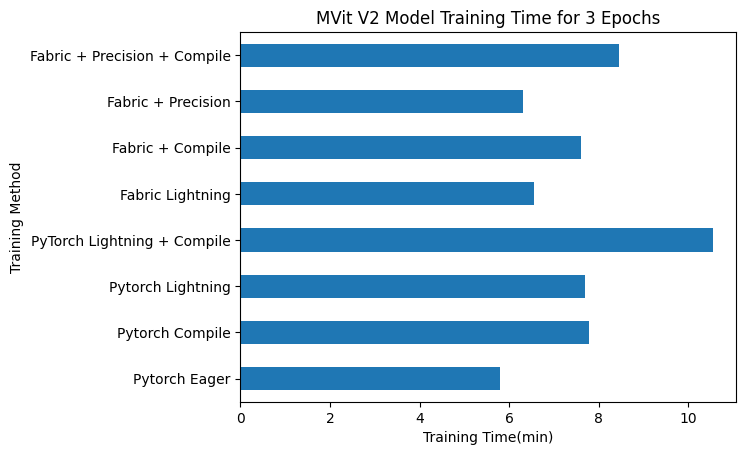

In [50]:
# plot the train time
model_train_time_df.plot.barh(x='model', 
                              y='training_time(min)', 
                              xlabel='Training Time(min)', 
                              ylabel='Training Method', 
                              legend=False)
plt.title(f'MVit V2 Model Training Time for {NUM_EPOCHS} Epochs')
plt.savefig('model_train_time.png')

## Training and Testing on Full Dataset and Deploying the Model

### Creating the model

In [51]:
NUM_CLASSES = 51
SEQUENCE_LENGTH = 16
BATCH_SIZE = 16
WORKERS = os.cpu_count()

In [52]:
# Creating the model and transforms using the function.
model, transforms = create_model(num_classes=NUM_CLASSES, device=device)

### Getting the Full Dataset and Dataloaders

In [53]:
# Creating the dataset.
dataset = HumanActionDataset(video_dir=DATA_PATH, 
                             seq_len=SEQUENCE_LENGTH,
                             num_classes=NUM_CLASSES,
                             transform=transforms)
train_dataset, test_dataset = random_split(dataset=dataset,
                                           lengths=[0.75, 0.25], 
                                           generator=torch.Generator().manual_seed(42))
print(f'Train Dataset Length: {len(train_dataset)} and Test Dataset length: {len(test_dataset)}')

# Creating the dataloaders
train_dataloader = create_dataloaders(dataset=train_dataset, batch=BATCH_SIZE, shuffle=True, workers=WORKERS)
test_dataloader = create_dataloaders(dataset=test_dataset, batch=BATCH_SIZE, shuffle=False, workers=WORKERS)

Train Dataset Length: 5075 and Test Dataset length: 1691
Dataloaders Length: 317 for a batch size of: 16
Dataloaders Length: 105 for a batch size of: 16


### Training Model for Full Dataset

In [55]:
set_seed(42)

# Intializing loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# Training the model using the pytorch function 
NUM_EPOCHS = 10
results, total_train_time = model_train(epochs=NUM_EPOCHS,
                                        model=model, 
                                        train_dataloader=train_dataloader, 
                                        test_dataloader=test_dataloader, 
                                        optimizer=optimizer, 
                                        loss_fn=loss_fn, 
                                        device=device, 
                                        num_classes=len(dataset.classes))

Training and Evaluation for 10 Epochs:   0%|          | 0/10 [00:00<?, ?epochs/s]

Model Training:   0%|          | 0/317 [00:00<?, ?batch/s]

Model Evaluation:   0%|          | 0/105 [00:00<?, ?batch/s]

Epoch: [1/10] | train_loss: 2.6020 | train_acc: 0.4720 | train_time: 4.8366 min | test loss: 1.8906 | test_acc: 0.6238 | test_time: 1.6950 min


Model Training:   0%|          | 0/317 [00:00<?, ?batch/s]

Model Evaluation:   0%|          | 0/105 [00:00<?, ?batch/s]

Epoch: [2/10] | train_loss: 1.8662 | train_acc: 0.6327 | train_time: 5.4221 min | test loss: 1.7076 | test_acc: 0.6607 | test_time: 1.5391 min


Model Training:   0%|          | 0/317 [00:00<?, ?batch/s]

Model Evaluation:   0%|          | 0/105 [00:00<?, ?batch/s]

Epoch: [3/10] | train_loss: 1.7319 | train_acc: 0.6642 | train_time: 4.8773 min | test loss: 1.6484 | test_acc: 0.6756 | test_time: 1.5405 min


Model Training:   0%|          | 0/317 [00:00<?, ?batch/s]

Model Evaluation:   0%|          | 0/105 [00:00<?, ?batch/s]

Epoch: [4/10] | train_loss: 1.6819 | train_acc: 0.6733 | train_time: 4.5695 min | test loss: 1.6199 | test_acc: 0.6887 | test_time: 1.5152 min


Model Training:   0%|          | 0/317 [00:00<?, ?batch/s]

Model Evaluation:   0%|          | 0/105 [00:00<?, ?batch/s]

Epoch: [5/10] | train_loss: 1.6426 | train_acc: 0.6936 | train_time: 4.3718 min | test loss: 1.6051 | test_acc: 0.6970 | test_time: 1.5019 min


Model Training:   0%|          | 0/317 [00:00<?, ?batch/s]

Model Evaluation:   0%|          | 0/105 [00:00<?, ?batch/s]

Epoch: [6/10] | train_loss: 1.6085 | train_acc: 0.6981 | train_time: 4.7581 min | test loss: 1.5919 | test_acc: 0.7000 | test_time: 1.5833 min


Model Training:   0%|          | 0/317 [00:00<?, ?batch/s]

Model Evaluation:   0%|          | 0/105 [00:00<?, ?batch/s]

Epoch: [7/10] | train_loss: 1.5967 | train_acc: 0.7049 | train_time: 4.9686 min | test loss: 1.5807 | test_acc: 0.7071 | test_time: 1.5994 min


Model Training:   0%|          | 0/317 [00:00<?, ?batch/s]

Model Evaluation:   0%|          | 0/105 [00:00<?, ?batch/s]

Epoch: [8/10] | train_loss: 1.5680 | train_acc: 0.7173 | train_time: 6.3247 min | test loss: 1.5763 | test_acc: 0.7137 | test_time: 1.5196 min


Model Training:   0%|          | 0/317 [00:00<?, ?batch/s]

Model Evaluation:   0%|          | 0/105 [00:00<?, ?batch/s]

Epoch: [9/10] | train_loss: 1.5577 | train_acc: 0.7179 | train_time: 5.6291 min | test loss: 1.5734 | test_acc: 0.7083 | test_time: 1.5351 min


Model Training:   0%|          | 0/317 [00:00<?, ?batch/s]

Model Evaluation:   0%|          | 0/105 [00:00<?, ?batch/s]

Epoch: [10/10] | train_loss: 1.5540 | train_acc: 0.7194 | train_time: 5.6172 min | test loss: 1.5605 | test_acc: 0.7185 | test_time: 1.5643 min

Total Model Training Time: 66.9688 min


### Storing Files for Demo App.

In [56]:
# Creating a directory for the app
demo_path = 'demo'
demo_project_path = os.path.join(demo_path, 'human_action_recognition')
demo_example_path = os.path.join(demo_project_path, 'examples')

if os.path.exists(demo_path):
    print(f'[INFO] "{demo_path}" already exists.')
else:
    os.mkdir(demo_path)
    os.mkdir(demo_project_path)
    os.mkdir(demo_example_path)
    print(f'[INFO] "{demo_project_path}" and "{demo_example_path}" directory is been created.')

[INFO] "demo/human_action_recognition" and "demo/human_action_recognition/examples" directory is been created.


In [57]:
# Saving some example files
example_files = ['data/shoot_bow/6arrowswithin30seconds_shoot_bow_f_nm_np1_fr_med_3.avi',
                 'data/golf/Golf_Tips_-_Hit_The_Driver_300+_Yards!!!_golf_f_nm_np1_fr_med_0.avi',
                 'data/climb/(HQ)_Rock_Climbing_-_Free_Solo_Speed_Climb_-_Dan_Osman_climb_f_cm_np1_le_med_2.avi',
                 'data/punch/AdvancedBoxingTechniquesandExercises_punch_u_nm_np1_ba_med_23.avi',
                 'data/swing_baseball/BaseballHitinSlowMotion_swing_baseball_f_nm_np1_fr_bad_0.avi']

for i in example_files:
    # Copying the files
    shutil.copy2(src=i, dst='demo/human_action_recognition/examples')
    print(f'{i} File is been copied.')

data/shoot_bow/6arrowswithin30seconds_shoot_bow_f_nm_np1_fr_med_3.avi File is been copied.
data/golf/Golf_Tips_-_Hit_The_Driver_300+_Yards!!!_golf_f_nm_np1_fr_med_0.avi File is been copied.
data/climb/(HQ)_Rock_Climbing_-_Free_Solo_Speed_Climb_-_Dan_Osman_climb_f_cm_np1_le_med_2.avi File is been copied.
data/punch/AdvancedBoxingTechniquesandExercises_punch_u_nm_np1_ba_med_23.avi File is been copied.
data/swing_baseball/BaseballHitinSlowMotion_swing_baseball_f_nm_np1_fr_bad_0.avi File is been copied.


In [58]:
# Saving the classes names to text file
class_names_path = os.path.join(demo_project_path, 'class_names.txt')

with open(class_names_path, 'w') as f:
    f.write('\n'.join(dataset.classes))
    print(f'[INFO] Saving class names to: "{class_names_path}"')

[INFO] Saving class names to: "demo/human_action_recognition/class_names.txt"


In [59]:
# Reading the text file
with open(class_names_path, 'r') as f:
    class_names_read = [i.strip() for i in f.readlines()]

class_names_read[:5]

['smoke', 'dive', 'cartwheel', 'throw', 'hit']

### Saving and Loading the Model

In [60]:
model_save_name = 'mvit_v2_pretrained_model_hmdb51.pth'
model_save_path = os.path.join(demo_project_path, model_save_name)

In [61]:
# saving the model state
torch.save(obj=model.state_dict(), 
           f=model_save_path)
print(f'[INFO] Model is been saved to: "{model_save_path}"')

[INFO] Model is been saved to: "demo/human_action_recognition/mvit_v2_pretrained_model_hmdb51.pth"


In [62]:
# loading the model state
model, transforms = create_model(num_classes=NUM_CLASSES, device=device)
model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

### Creating a text file for Modules and Packages

In [63]:
%%writefile demo/human_action_recognition/requirements.txt
av==10.0.0
torch==2.0.0
torchvision==0.15.1
torchaudio==2.0.1
gradio==3.24.1

Writing demo/human_action_recognition/requirements.txt


### Creating a Python Script to Preprocess the Data

In [64]:
%%writefile demo/human_action_recognition/utils.py
import torch
import torchvision

def preprocess_video(video: str):
    """
    A function to preprocess the video file before going into the model.
    Parameters: 
        video: str, A string for the video file path.
    Returns: selected_frame: torch.Tensor, A tensor of shape 'TCHW'.
    """
    # Reading the video file
    vframes, _, _ = torchvision.io.read_video(filename=video, pts_unit='sec', output_format='TCHW')
    vframes = vframes.type(torch.float32)
    vframes_count = len(vframes)
    
    # Selecting frames at certain interval
    skip_frames = max(int(vframes_count/16), 1)
    
    # Selecting the first frame
    selected_frame = vframes[0].unsqueeze(0)
    
    # Creating a new sequence of frames upto the defined sequence length.
    for i in range(1, 16):
        selected_frame = torch.concat((selected_frame, vframes[i * skip_frames].unsqueeze(0)))
    return selected_frame

Writing demo/human_action_recognition/utils.py


### Creating a Python Script to Create the Model

In [65]:
%%writefile demo/human_action_recognition/model.py
import torch
import torchvision

def create_model(num_classes: int, seed: int = 42):
    """
    A function to create a model.
    Parameters:
        num_classes: int, A integer for toal number of classes.
        seed: int(default: 42), A random seed value.
    Returns: 
        model: A feature extracted model for video classification.
        transforms: A torchvision transform is returned which was used in the pretrained model.    
    """
    # Creating model, weights and transforms
    weights = torchvision.models.video.MViT_V2_S_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.video.mvit_v2_s(weights=weights)
    
    # Freezing the model layers
    for params in model.parameters():
        params.requires_grad = False
        
    # Changing the fully Conncected head layer
    torch.manual_seed(seed)
    dropout_layer = model.head[0]
    in_features = model.head[1].in_features
    model.head = torch.nn.Sequential(
        dropout_layer,
        torch.nn.Linear(in_features=in_features, out_features=num_classes, bias=True)
    )
    return model, transforms

Writing demo/human_action_recognition/model.py


### Creating a Python Script for Gradio App

In [66]:
%%writefile demo/human_action_recognition/app.py
import gradio as gr
import os
import torch
import torchvision
from timeit import default_timer as timer
from model import create_model
from utils import preprocess_video

# Configuring the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Setting class names using the text file
with open('class_names.txt', 'r') as f:
    class_names = [i.strip() for i in f.readlines()]

# Setting the model and transforms
model, transforms = create_model(num_classes=len(class_names), seed=42)
model.load_state_dict(torch.load(f='mvit_v2_pretrained_model_hmdb51.pth', map_location=device))

# Creating a function to predict the video
def predict(video_file):
    """
    A function to predict the video using the model.
    Parameters: 
        video_file: str, A video file path as a string.
    Returns: 
        pred_labels_probs: A dict file containing the class names and confidence values.
        pred_time: Time taken to predict in seconds.
    """
    # Preprocessing the video file
    frames = preprocess_video(video=video_file)
    
    # transforming the frames
    mod_frames = transforms(frames).unsqueeze(dim=0)
    
    # Starting the timer and predicting using the model
    start_time = timer()
    model.eval()
    
    # forward pass
    with torch.no_grad():
        logits = model(mod_frames.to(device)) 
        pred_probs = torch.softmax(logits, dim=1).squeeze(dim=0)
    
    # Creating a dict with class names and their predicted probabilities
    pred_labels_probs = {class_names[i]: float(pred_probs[i]) for i in range(len(class_names))}
        
    # Ending the timer and calculating the prediction time.
    end_time = timer()
    pred_time = round(end_time - start_time, 5)
    
    # Returning the labels and time for gradio output.
    return pred_labels_probs, pred_time

# Pre-information for interface
title = 'Human Activity Recognition(HAR)'
description = 'A Gradio demo web application for video classification using the MViT V2 Pretrained Model and trained on the HMDB51 Dataset.'
article = 'Created by John'
example_list = [['examples/'+ i] for i in os.listdir('examples')]

# Building the Gradio interface
demo = gr.Interface(fn=predict,
                    inputs=gr.Video(label='Video'),
                    outputs=[gr.Label(num_top_classes=5, label='Predictions'),
                             gr.Number(label='Prediction Time (sec)')],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launching the gradio interface
demo.launch()

Writing demo/human_action_recognition/app.py


### Deploying on HuggingFace

In [67]:
IFrame(src='https://hf.space/embed/JohnPinto/Human_Activity_Recognition-HAR-Video_Classification-HMDB51-Dataset',
       width=1050,
       height=700)